# Feedforward Neural Network Programming

## What am I doing?

Before jumping into libraries like TensorFlow or PyTorch, I'll be learning to code a feed-forward neural net from scratch with binary classification (https://en.wikipedia.org/wiki/Feedforward_neural_network)

<img src='https://upload.wikimedia.org/wikipedia/en/5/54/Feed_forward_neural_net.gif' width=50%></img>
<center>Src: Wikipedia</center>

My aims from doing this are:
* an in-depth understanding of neural nets (activation functions, vector operations)
* practicing Python
* applying mathematical knowledge learned from my fundamentals class

I will limit myself to the following libraries:
* numpy
* scipy
* math
* and other plotting functions

## Base understanding comes from:

* 3Blue1Brown's excellent series: <a href='https://www.youtube.com/watch?v=aircAruvnKk&ab_channel=3Blue1Brown'>here</a>
* sentdexs' guidance at: <a href='https://www.youtube.com/watch?v=Wo5dMEP_BbI&list=PLQVvvaa0QuDcjD5BAw2DxE6OF2tius3V3&index=1&t=37s&ab_channel=sentdex'>here</a>
* Brandon Rohrer's explanation at: <a href='https://www.youtube.com/watch?v=ILsA4nyG7I0&ab_channel=BrandonRohrer'>here</a>

...and Wikipedia!

Having already watched and read this guidance, I will try implement the code from mathematical formulas without too much other guidance. If I am using guidance, it will be referenced as such.

## Why Jupyter notebook?

So I can add markdown cells as I learn!

### Details

Let's try initially:

* 2 Inputs (1 Input for testing)
* Hidden layers (4 neurons, 2 layers, 1 bias for each layer)
* 1 output

### High Level Concept Drawing along with Feedforward matrix sizes

<img src='./ff_concept.jpg'></img>

In [1]:
# Imports

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
%matplotlib inline

### Step 0 - Generate some dummy data to test

(admittedly, the below took a bit too long to figure out)

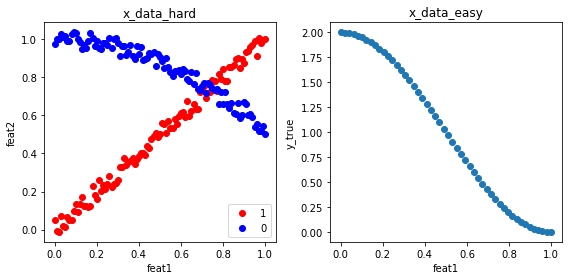

In [63]:
# To do: create data_set with obvious features

np.random.seed(100)

# Single Record for Testing
x_data_1 = np.random.rand(2,2) # two record with two features for testing
y_data_1 = np.random.rand(2,1)

# Double record for Testing
x_data_2 = np.random.rand(2,2) # two records with two features for testing

# Create an easy dataset - one numerical input and one numerical output (actually a sin relationship)

x_data_easy = np.linspace(0,1).reshape(-1,1) # cos relationship for testing
y_data_easy = np.cos((x_data_easy)*3.14)+1

# Create a hard dataset - two inputs (feat1, feat2) and classification output (1, or 0). 1s have actually have a linear
# relationship between feats1 and feat2 and 0s have a cosine relationship between feat1 and feat2 with a bit of
# noise added in

x1_data_hard_1 = np.linspace(0,1,num=101,axis=0).reshape(-1,1)
x2_data_hard_1 = np.linspace(0,1,num=101,axis=0).reshape(-1,1) + np.random.default_rng().uniform(-0.05,0.05,size=(101,1))

x_data_hard_cluster1 = np.hstack((x1_data_hard_1, x2_data_hard_1))

x1_data_hard_2 = np.linspace(0,1,num=101,axis=0).reshape(-1,1)
x2_data_hard_2 = np.cos(np.linspace(0,1,num=101,axis=0).reshape(-1,1)) + np.random.default_rng().uniform(-0.05,0.05,size=(101,1))

x_data_hard_cluster2 = np.hstack((x1_data_hard_2, x2_data_hard_2))

x_data_hard = np.vstack((x_data_hard_cluster1, x_data_hard_cluster2))

y_data_hard = np.zeros(shape=(len(x_data_hard),1))
y_data_hard[:len(x_data_hard_cluster1)] = 1

# Let's have a look at just the first column of this to ensure random variables came out correctly

fig, ax = plt.subplots(1, 2, figsize=(8,4))

ax[0].scatter(x_data_hard[:len(x_data_hard_cluster1),0], x_data_hard[:len(x_data_hard_cluster1),1], color='red',label='1')
ax[0].scatter(x_data_hard[len(x_data_hard_cluster1):,0], x_data_hard[len(x_data_hard_cluster1):,1], color='blue',label='0')
ax[0].set_title('x_data_hard')
ax[0].legend()
ax[0].set_xlabel('feat1')
ax[0].set_ylabel('feat2')
ax[1].scatter(x_data_easy, y_data_easy)
ax[1].set_title('x_data_easy')
ax[1].set_xlabel('feat1')
ax[1].set_ylabel('y_true')

fig.tight_layout()
plt.show()

### Step 1 - Activation Functions

Let's start by coding a class which holds our various activation functions, so that they can be called upon at anytime.

We will program this similar to how sklearn and other such libraries hold unique models (i.e. the ActivationFunction class will be instantiated, and the various methods will be the different activation functions)

We will take a couple popular examples from the Wiki page: https://en.wikipedia.org/wiki/Activation_function

Specifically:

* Identity: <img src='https://wikimedia.org/api/rest_v1/media/math/render/svg/87f9e315fd7e2ba406057a97300593c4802b53e4'></img>
* Sigmoid: <img src='https://wikimedia.org/api/rest_v1/media/math/render/svg/b2a78e39c42d7d51c4041d142740a7719e55b314'></img>
* Hyperbolic Tangent: <img src='https://wikimedia.org/api/rest_v1/media/math/render/svg/f8e81902c8d71b06c246769bad0fe17c9cf1efd9'></img>
* ReLU: <img src='https://wikimedia.org/api/rest_v1/media/math/render/svg/281532984565d3931de1cd1edc6e006d59fc67f4'></img>
* Softmax: <img src='https://wikimedia.org/api/rest_v1/media/math/render/svg/3bbfe09d9d37eb94cd7a86b1bdfa24fc60e4cba5'></img>

The Softmax function does not take in a singular input unlike the other functions but rather deals with multidimensional data. As such, I have referred to the following deepai.org article which has explained it: refer <a href='https://deepai.org/machine-learning-glossary-and-terms/softmax-layer'>here</a>

In [501]:
class ActivationFunction():
    
    """The inputs to the methods of the ActivationFunction object will be x,
    ise numpy where possible as we may want to take in multiple scalars"""
    
    # Class variables
    
    def __init__(self):
        self.af_types = ['identity', 'sigmoid', 'hyperbolic_tangent', 'relu', 'softmax']
    
    def identity(self, x):
        return x
    
    def identity_deriv(self, x):
        return 1
    
    def sigmoid(self, x):
        y = (1)/(1+np.exp(-x))
        return y
    
    def sigmoid_deriv(self, x):
        dx = x*(1-x)
        return dx
    
    def hyperbolic_tangent(self, x):
        x_temp = np.copy(x)
        y = (np.exp(x_temp) - np.exp(-x_temp))/(np.exp(x_temp) + np.exp(-x_temp))
        return y
    
    def hyperbolic_tangent_deriv(self, x):
        
        return (1-x**2)
    
    def relu(self, x):
        
        y = np.copy(x)
        y[y < 0] = 0
        return y
        
    def relu_deriv(self, x):
        
#         print('relu deriv input: ',x)
        
        x[x>=0] = 1
        x[x<0] = 0
        
#         print('relu deriv output: ',x)
        
        return x
        
    def softmax(self, x_array):
        
        """Note that Softmax function takes a vector as an input and outputs a vector"""
        
        x_array = x_array.copy()
        
        y_array = np.exp(x_array)
        
        y_array_sum = np.sum(y_array, axis=1, keepdims=True)
        
        return y_array / y_array_sum    

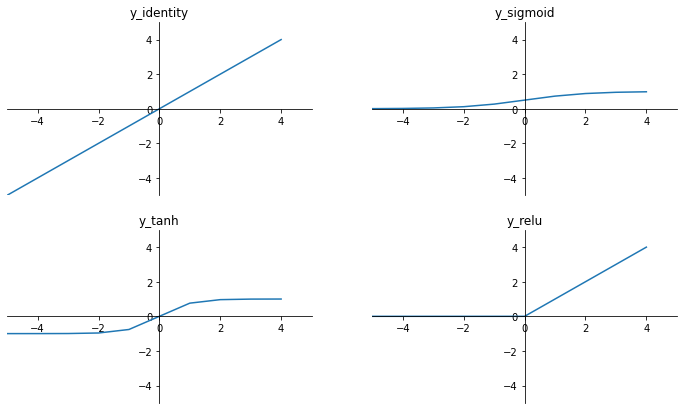

In [502]:
# Let's see if it worked

af = ActivationFunction()

# initialise some test x data
test_x = np.arange(-5,5)

# use the activation function to generate y

y_identity = af.identity(test_x)
y_sigmoid = af.sigmoid(test_x)
y_tanh = af.hyperbolic_tangent(test_x)
y_relu = af.relu(test_x)

list_all = ['y_identity', 'y_sigmoid', 'y_tanh', 'y_relu']

# plot them

fig, ax = plt.subplots(2,2,figsize=(12,7))

for i, ax in zip(list_all, ax.flat):
    
    y = globals()[i]
    
    ax.plot(test_x, y)
    ax.set_xlim(left=-5,right=5)
    ax.set_ylim(bottom=-5,top=5)
    ax.set_title(str(i))
    ax.spines['left'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['bottom'].set_position('zero')
    ax.spines['top'].set_color('none')


plt.show()

The above doesn't look too shabby, so the activation functions look like they're working!

### Step 2 - the Layer

Let's start by coding out a class for the Layer and give it a couple methods such as how the neurons will be calculated

Note: my initial idea was to code the <b>neuron</b> but in hindisght this made it incredibly difficult as we would have to intialise many neurons. Instead we will code a layer, which will take as a parameter the number of neurons.

<b>Feed forwarding</b> is defined as:

<img src='https://www.researchgate.net/profile/Lin-Fritschi/publication/8332488/figure/fig2/AS:601679661633573@1520463018727/Simplified-representation-of-an-individual-neuron-showing-inputs-weights-weighted-sum.png'></img>

We will also create the following functions:
* intialising random weights
* initialising random biases

In [518]:
class Dense_Layer():
    
    af = ActivationFunction()
    
    def __init__(self, size, input_size, activation = 'relu', weights = None, biases = None, values = None, overflow_protect = False): 
        
        # activation function selection
        if activation not in af.af_types:  
            raise ValueError('Please only choose an activation function in {}'.format(af.af_types))
        else:
            self.activation = activation
        
        self.weights = weights
        self.size = size
        self.biases = biases
        self.overflow_protect = overflow_protect
        self.input_size = input_size
        self.values = None
        
        # for backprop
        
        self.delta = 0
        self.error = 0
        self.delta_b = 0
        
    def randomise_weights(self):
        
        """If no weights have been pre-selected, intialise weights with random values between 0 and 1"""
        """Size expected will be (number of neurons in input * number of neurons)"""
        
        self.weights = np.random.normal(scale=0.5,size=(self.input_size, self.size))
        
    def randomise_biases(self):
        
        """Randomise biases"""
        """Size expected will be (1 * number of neurons)"""
        
        self.biases = np.random.normal(scale=0.5,size=self.size)

    def feedforward(self, x):
        
        """Feed forward is just the dot product of the weights and inputs + the biases, which are then subject to 
        some sort of activation function"""
        
        # Ensure that weights and biases are not None
        
        if self.weights is None: self.randomise_weights()
        
        if self.biases is None: self.randomise_biases()
        
        if self.input_size == self.weights.shape[0]: # ensure that shape size of matrix multiplication is appropriate 
            
            pre_activation_vals = (np.dot(x, self.weights) + self.biases)
            
            # check if overflow protection is on, and if so, reduce pre activation vals by max
            
            if self.overflow_protect:
                
                pre_activation_vals = pre_activation_vals - np.max(pre_activation_vals, axis=1, keepdims=True)
            
            self.values = getattr(af, self.activation)(pre_activation_vals)
            
        else:
            raise ValueError('Length of weights and input array do not match!')
            
        return self.values
    
    def derivative(self, y):
        
        return getattr(af, self.activation + '_deriv')(y)
        
        
        
    def __len__(self):
        return self.size
    
    
    def __str__(self):
        
        np.set_printoptions(precision=3) # make sure prints okay
        
        if self.values is None: self.values = ""
        
        
        return "=======================================\nDense Layer\n=======================================\
        \n\nWeights: \n {}\n\nBiases: \n {}\n\nValues: \n {}".format(self.weights, self.biases, self.values)
        
    

### Creating a NeuralNetModel class

Now that the layers have been created, it's appropriate time to create a class so that we don't have to recreate the layers and connect them manually.

For backprop: I have referred here: https://www.youtube.com/watch?v=ZVi647MYeXU&list=PLPOTBrypY74wOpTIWQhqNdfV5gIt1h1fa&index=13&ab_channel=SebastianMantey

In [623]:
class NeuralNetModel():
    
    def __init__(self, layer_order = list()):
        
        self.layer_order = layer_order
        self.costs = None
        
    def append(self, layer):
        
        layer_order.append(layer)
        
    def feedforward(self, X):
        
        # skip first layer
        
        for layer in self.layer_order:
            
            X = layer.feedforward(X)
            
            
        return self.layer_order[-1].values
    
    def loss_mse(self, X, y_true): # can probably move this to another metric function
        
        # need to rebuild later
        # build simply for MSE with 1 output node
        
        output_val = self.feedforward(X)

        n = len(output_val)
        
        print('lossmse:',y_true,'\n\n', output_val)

        mse = np.sum(np.power((y_true - output_val),2)) / 2

        return mse

    def backprop_mse(self, X, y_true, alpha):
        
        # hardkey: mse, relu
        
        output=self.feedforward(X)
        
        for i in reversed(range(len(self.layer_order))):
            
            layer = self.layer_order[i]
            
            if layer == self.layer_order[-1]:
                
                layer.error = y_true - output # this is the derivative already (dMSE / dA)
                
                layer.delta = layer.error * layer.derivative(output) # this is just dA / dZ
            
                layer.delta_b = np.sum(layer.delta,axis=0,keepdims=True)
                
#                 print('y_true',y_true)
#                 print('output',output)
#                 print('error',layer.error)
#                 print('layer deriv: ',layer.derivative(output))
#                 print('delta', layer.delta,'\n\n')
                
            else:
                
                next_layer = self.layer_order[i+1]
                
                layer.error = np.dot(next_layer.weights, next_layer.delta) # delta between layers dZ / dA
                
                layer.delta = layer.error * layer.derivative(layer.values) # dA / dZ
                
                layer.delta_b = np.sum(layer.delta,axis=0,keepdims=True) # sum of delta which is = bias as bias is just calculation of delta but summed (dCost / dw change to db results in 1 * rest of chain rule)
                
        for i in range(len(self.layer_order)):
            
            layer = self.layer_order[i]
            
            # the outputs to multiple this against (hidden layers or inputs)
            input_to_use = np.atleast_2d(X if i == 0 else self.layer_order[i - 1].values)

            layer.weights += (layer.delta * input_to_use.T * alpha)
            layer.biases += (layer.delta_b * alpha) # check if bias implemented propertly
            
    def train(self, X, y, alpha, max_epochs, verbose):
            
        costs = []

        for i in range(max_epochs):
            
            for j in range(len(X)):
                
                self.backprop_mse(X[j], y[j], alpha)
                
            # append costs
            cost_mse = np.mean(np.square(y - self.feedforward(X)))
            costs.append((i,cost_mse))

            # verbose printing
            if verbose and i % 10 == 0: print('Epoch Num: {}, MSE: {:.3f}'.format(i, cost_mse))
                
        print('finished')
        
        self.costs = costs

        return costs
        
        

In [624]:
num_hidden_layers = 60

hid_lay1 = Dense_Layer(input_size=1, size = num_hidden_layers,activation='hyperbolic_tangent')
hid_lay2 = Dense_Layer(input_size=num_hidden_layers, size = num_hidden_layers, activation='hyperbolic_tangent')
output_lay1 = Dense_Layer(input_size=num_hidden_layers, size = 1, activation='relu')

model = NeuralNetModel([hid_lay1, hid_lay2, output_lay1])

errors = model.train(x_data_easy, y_data_easy, 0.001, 200, verbose=True)

Epoch Num: 0, MSE: 0.179
Epoch Num: 10, MSE: 0.002
Epoch Num: 20, MSE: 0.001
Epoch Num: 30, MSE: 0.001
Epoch Num: 40, MSE: 0.001
Epoch Num: 50, MSE: 0.001
Epoch Num: 60, MSE: 0.001
Epoch Num: 70, MSE: 0.001
Epoch Num: 80, MSE: 0.001
Epoch Num: 90, MSE: 0.001
Epoch Num: 100, MSE: 0.001
Epoch Num: 110, MSE: 0.001
Epoch Num: 120, MSE: 0.001
Epoch Num: 130, MSE: 0.001
Epoch Num: 140, MSE: 0.001
Epoch Num: 150, MSE: 0.001
Epoch Num: 160, MSE: 0.001
Epoch Num: 170, MSE: 0.001
Epoch Num: 180, MSE: 0.001
Epoch Num: 190, MSE: 0.001
finished


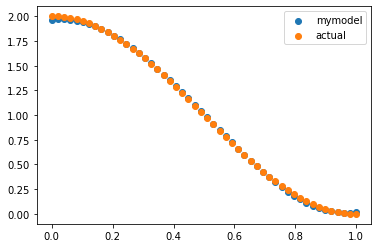

In [618]:
y_pred = model.feedforward(x_data_easy)

fig, ax = plt.subplots()

ax.scatter(x_data_easy, y_pred,label='mymodel')
ax.scatter(x_data_easy, y_data_easy,label='actual')
ax.legend()
plt.show()

finished
finished
finished


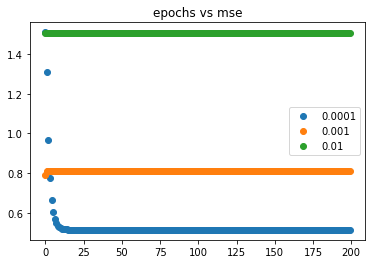

In [620]:
test_alphas = [0.0001, 0.001, 0.01]

fig, ax = plt.subplots()

for alpha in test_alphas:
    
    costs = model.train(x_data_easy, y_data_easy, alpha, 200, verbose=False)
    array_costs = np.array(costs)
    
    x = array_costs[:,0]
    y = array_costs[:,1]
    
    ax.scatter(x, y,label=alpha)

ax.legend()
ax.set_title('epochs vs mse')
plt.show()

### Calculating Loss

So I've actually generated two types of example data above

* Regression: we will implement mean squared log error 
* Classification: we will implement binary cross entropy (we don't need multi-class cross entropy but will have a look at for completeness)

I've referred to this webpage on machinelearningmastery <a href='https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/'>here</a>.

I attempt to implement a few of these loss functions.

Calculating backprop:

derivative of outputlayer MSE (https://math.stackexchange.com/questions/289989/first-and-second-derivative-of-a-summation)

# Using Keras to create the same model

In [64]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [346]:
model2 = Sequential()

model2.add(Dense(12,input_dim =1,activation='relu'))
model2.add(Dense(12,activation='relu'))
model2.add(Dense(12,activation='relu'))
model2.add(Dense(1))

model2.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

In [379]:
model2.fit(x_data_easy, y_data_easy, epochs = 2200, batch_size=1)

Epoch 1/2200
50/50 [==============================] - 0s 624us/step - loss: 5.7742e-05 - accuracy: 0.0000e+00
Epoch 2/2200
50/50 [==============================] - 0s 490us/step - loss: 6.8700e-05 - accuracy: 0.0000e+00
Epoch 3/2200
50/50 [==============================] - 0s 536us/step - loss: 5.2252e-05 - accuracy: 0.0000e+00
Epoch 4/2200
50/50 [==============================] - 0s 495us/step - loss: 8.6459e-05 - accuracy: 0.0000e+00
Epoch 5/2200
50/50 [==============================] - 0s 556us/step - loss: 7.7831e-05 - accuracy: 0.0000e+00
Epoch 6/2200
50/50 [==============================] - 0s 488us/step - loss: 6.1239e-05 - accuracy: 0.0000e+00
Epoch 7/2200
50/50 [==============================] - 0s 513us/step - loss: 5.5408e-05 - accuracy: 0.0000e+00
Epoch 8/2200
50/50 [==============================] - 0s 564us/step - loss: 5.2640e-05 - accuracy: 0.0000e+00
Epoch 9/2200
50/50 [==============================] - 0s 525us/step - loss: 5.0557e-05 - accuracy: 0.0000e+00
Epoch 10/2

50/50 [==============================] - 0s 448us/step - loss: 2.2713e-04 - accuracy: 0.0000e+00
Epoch 148/2200
50/50 [==============================] - 0s 485us/step - loss: 2.3181e-04 - accuracy: 0.0000e+00
Epoch 149/2200
50/50 [==============================] - 0s 519us/step - loss: 1.6074e-04 - accuracy: 0.0000e+00
Epoch 150/2200
50/50 [==============================] - 0s 468us/step - loss: 7.8411e-05 - accuracy: 0.0000e+00
Epoch 151/2200
50/50 [==============================] - 0s 439us/step - loss: 1.1572e-04 - accuracy: 0.0000e+00
Epoch 152/2200
50/50 [==============================] - 0s 449us/step - loss: 6.7885e-04 - accuracy: 0.0000e+00
Epoch 153/2200
50/50 [==============================] - 0s 448us/step - loss: 6.1526e-04 - accuracy: 0.0000e+00
Epoch 154/2200
50/50 [==============================] - 0s 448us/step - loss: 2.3941e-04 - accuracy: 0.0000e+00
Epoch 155/2200
50/50 [==============================] - 0s 508us/step - loss: 1.3411e-04 - accuracy: 0.0000e+00
Epoch 1

50/50 [==============================] - 0s 447us/step - loss: 4.5560e-05 - accuracy: 0.0000e+00
Epoch 292/2200
50/50 [==============================] - 0s 462us/step - loss: 1.1148e-04 - accuracy: 0.0000e+00
Epoch 293/2200
50/50 [==============================] - 0s 468us/step - loss: 3.9369e-04 - accuracy: 0.0000e+00
Epoch 294/2200
50/50 [==============================] - 0s 428us/step - loss: 3.7961e-04 - accuracy: 0.0000e+00
Epoch 295/2200
50/50 [==============================] - 0s 470us/step - loss: 7.7362e-04 - accuracy: 0.0000e+00
Epoch 296/2200
50/50 [==============================] - 0s 411us/step - loss: 2.9702e-04 - accuracy: 0.0000e+00
Epoch 297/2200
50/50 [==============================] - 0s 468us/step - loss: 6.3124e-05 - accuracy: 0.0000e+00
Epoch 298/2200
50/50 [==============================] - 0s 435us/step - loss: 1.8520e-04 - accuracy: 0.0000e+00
Epoch 299/2200
50/50 [==============================] - 0s 446us/step - loss: 1.3227e-04 - accuracy: 0.0000e+00
Epoch 3

Epoch 436/2200
50/50 [==============================] - 0s 489us/step - loss: 1.4710e-04 - accuracy: 0.0000e+00
Epoch 437/2200
50/50 [==============================] - 0s 427us/step - loss: 8.5309e-05 - accuracy: 0.0000e+00
Epoch 438/2200
50/50 [==============================] - 0s 488us/step - loss: 4.3074e-05 - accuracy: 0.0000e+00
Epoch 439/2200
50/50 [==============================] - 0s 448us/step - loss: 6.1796e-05 - accuracy: 0.0000e+00
Epoch 440/2200
50/50 [==============================] - 0s 448us/step - loss: 9.5848e-05 - accuracy: 0.0000e+00
Epoch 441/2200
50/50 [==============================] - 0s 463us/step - loss: 8.5686e-04 - accuracy: 0.0000e+00
Epoch 442/2200
50/50 [==============================] - 0s 468us/step - loss: 4.5150e-04 - accuracy: 0.0000e+00
Epoch 443/2200
50/50 [==============================] - 0s 447us/step - loss: 4.2773e-04 - accuracy: 0.0000e+00
Epoch 444/2200
50/50 [==============================] - 0s 427us/step - loss: 1.8566e-04 - accuracy: 0.0

50/50 [==============================] - 0s 427us/step - loss: 7.2333e-05 - accuracy: 0.0000e+00
Epoch 583/2200
50/50 [==============================] - 0s 456us/step - loss: 3.3254e-04 - accuracy: 0.0000e+00
Epoch 584/2200
50/50 [==============================] - 0s 424us/step - loss: 2.5347e-04 - accuracy: 0.0000e+00
Epoch 585/2200
50/50 [==============================] - 0s 470us/step - loss: 3.8480e-04 - accuracy: 0.0000e+00
Epoch 586/2200
50/50 [==============================] - 0s 454us/step - loss: 3.7836e-04 - accuracy: 0.0000e+00
Epoch 587/2200
50/50 [==============================] - 0s 428us/step - loss: 2.1997e-04 - accuracy: 0.0000e+00
Epoch 588/2200
50/50 [==============================] - 0s 448us/step - loss: 1.3891e-04 - accuracy: 0.0000e+00
Epoch 589/2200
50/50 [==============================] - 0s 441us/step - loss: 8.3349e-05 - accuracy: 0.0000e+00
Epoch 590/2200
50/50 [==============================] - 0s 457us/step - loss: 5.5638e-05 - accuracy: 0.0000e+00
Epoch 5

50/50 [==============================] - 0s 493us/step - loss: 3.8579e-05 - accuracy: 0.0000e+00
Epoch 727/2200
50/50 [==============================] - 0s 488us/step - loss: 2.9781e-05 - accuracy: 0.0000e+00
Epoch 728/2200
50/50 [==============================] - 0s 489us/step - loss: 5.5606e-05 - accuracy: 0.0000e+00
Epoch 729/2200
50/50 [==============================] - 0s 529us/step - loss: 4.1552e-05 - accuracy: 0.0000e+00
Epoch 730/2200
50/50 [==============================] - 0s 501us/step - loss: 2.2498e-05 - accuracy: 0.0000e+00
Epoch 731/2200
50/50 [==============================] - 0s 509us/step - loss: 4.6755e-05 - accuracy: 0.0000e+00
Epoch 732/2200
50/50 [==============================] - 0s 432us/step - loss: 3.4617e-05 - accuracy: 0.0000e+00
Epoch 733/2200
50/50 [==============================] - 0s 468us/step - loss: 5.9732e-05 - accuracy: 0.0000e+00
Epoch 734/2200
50/50 [==============================] - 0s 499us/step - loss: 3.1339e-05 - accuracy: 0.0000e+00
Epoch 7

50/50 [==============================] - 0s 452us/step - loss: 1.5759e-04 - accuracy: 0.0000e+00
Epoch 872/2200
50/50 [==============================] - 0s 436us/step - loss: 6.7787e-05 - accuracy: 0.0000e+00
Epoch 873/2200
50/50 [==============================] - 0s 448us/step - loss: 4.3069e-05 - accuracy: 0.0000e+00
Epoch 874/2200
50/50 [==============================] - 0s 527us/step - loss: 4.8450e-05 - accuracy: 0.0000e+00
Epoch 875/2200
50/50 [==============================] - 0s 577us/step - loss: 2.2294e-05 - accuracy: 0.0000e+00
Epoch 876/2200
50/50 [==============================] - 0s 489us/step - loss: 3.4329e-05 - accuracy: 0.0000e+00
Epoch 877/2200
50/50 [==============================] - 0s 428us/step - loss: 6.7191e-05 - accuracy: 0.0000e+00
Epoch 878/2200
50/50 [==============================] - 0s 522us/step - loss: 1.5761e-04 - accuracy: 0.0000e+00
Epoch 879/2200
50/50 [==============================] - 0s 448us/step - loss: 3.6290e-05 - accuracy: 0.0000e+00
Epoch 8

50/50 [==============================] - 0s 468us/step - loss: 1.7918e-04 - accuracy: 0.0000e+00
Epoch 1017/2200
50/50 [==============================] - 0s 456us/step - loss: 2.4729e-04 - accuracy: 0.0000e+00
Epoch 1018/2200
50/50 [==============================] - 0s 488us/step - loss: 4.8701e-04 - accuracy: 0.0000e+00
Epoch 1019/2200
50/50 [==============================] - 0s 449us/step - loss: 2.4211e-04 - accuracy: 0.0000e+00
Epoch 1020/2200
50/50 [==============================] - 0s 514us/step - loss: 2.5547e-04 - accuracy: 0.0000e+00
Epoch 1021/2200
50/50 [==============================] - 0s 542us/step - loss: 2.8810e-04 - accuracy: 0.0000e+00
Epoch 1022/2200
50/50 [==============================] - 0s 500us/step - loss: 8.8727e-05 - accuracy: 0.0000e+00
Epoch 1023/2200
50/50 [==============================] - 0s 512us/step - loss: 1.1439e-04 - accuracy: 0.0000e+00
Epoch 1024/2200
50/50 [==============================] - 0s 432us/step - loss: 8.5878e-05 - accuracy: 0.0000e+00

50/50 [==============================] - 0s 448us/step - loss: 2.3898e-05 - accuracy: 0.0000e+00
Epoch 1160/2200
50/50 [==============================] - 0s 491us/step - loss: 2.2129e-05 - accuracy: 0.0000e+00
Epoch 1161/2200
50/50 [==============================] - 0s 509us/step - loss: 4.5901e-05 - accuracy: 0.0000e+00
Epoch 1162/2200
50/50 [==============================] - 0s 529us/step - loss: 4.8625e-05 - accuracy: 0.0000e+00
Epoch 1163/2200
50/50 [==============================] - 0s 536us/step - loss: 1.2879e-04 - accuracy: 0.0000e+00
Epoch 1164/2200
50/50 [==============================] - 0s 509us/step - loss: 8.0190e-05 - accuracy: 0.0000e+00
Epoch 1165/2200
50/50 [==============================] - 0s 529us/step - loss: 2.3909e-04 - accuracy: 0.0000e+00
Epoch 1166/2200
50/50 [==============================] - 0s 489us/step - loss: 6.8486e-05 - accuracy: 0.0000e+00
Epoch 1167/2200
50/50 [==============================] - 0s 488us/step - loss: 2.0185e-05 - accuracy: 0.0000e+00

50/50 [==============================] - 0s 448us/step - loss: 1.0463e-05 - accuracy: 0.0000e+00
Epoch 1304/2200
50/50 [==============================] - 0s 504us/step - loss: 1.2558e-05 - accuracy: 0.0000e+00
Epoch 1305/2200
50/50 [==============================] - 0s 502us/step - loss: 2.5461e-05 - accuracy: 0.0000e+00
Epoch 1306/2200
50/50 [==============================] - 0s 488us/step - loss: 5.1791e-05 - accuracy: 0.0000e+00
Epoch 1307/2200
50/50 [==============================] - 0s 454us/step - loss: 5.3156e-05 - accuracy: 0.0000e+00
Epoch 1308/2200
50/50 [==============================] - 0s 570us/step - loss: 2.9280e-05 - accuracy: 0.0000e+00
Epoch 1309/2200
50/50 [==============================] - 0s 529us/step - loss: 6.5542e-05 - accuracy: 0.0000e+00
Epoch 1310/2200
50/50 [==============================] - 0s 509us/step - loss: 1.4166e-04 - accuracy: 0.0000e+00
Epoch 1311/2200
50/50 [==============================] - 0s 529us/step - loss: 2.0390e-04 - accuracy: 0.0000e+00

50/50 [==============================] - 0s 448us/step - loss: 1.1756e-05 - accuracy: 0.0000e+00
Epoch 1448/2200
50/50 [==============================] - 0s 448us/step - loss: 2.2735e-05 - accuracy: 0.0000e+00
Epoch 1449/2200
50/50 [==============================] - 0s 427us/step - loss: 2.3067e-05 - accuracy: 0.0000e+00
Epoch 1450/2200
50/50 [==============================] - 0s 448us/step - loss: 2.3490e-05 - accuracy: 0.0000e+00
Epoch 1451/2200
50/50 [==============================] - 0s 451us/step - loss: 3.2991e-05 - accuracy: 0.0000e+00
Epoch 1452/2200
50/50 [==============================] - 0s 508us/step - loss: 1.0263e-04 - accuracy: 0.0000e+00
Epoch 1453/2200
50/50 [==============================] - 0s 494us/step - loss: 7.7716e-05 - accuracy: 0.0000e+00
Epoch 1454/2200
50/50 [==============================] - 0s 449us/step - loss: 2.1208e-05 - accuracy: 0.0000e+00
Epoch 1455/2200
50/50 [==============================] - 0s 448us/step - loss: 5.1174e-05 - accuracy: 0.0000e+00

50/50 [==============================] - 0s 471us/step - loss: 2.0292e-05 - accuracy: 0.0000e+00
Epoch 1591/2200
50/50 [==============================] - 0s 448us/step - loss: 2.4123e-05 - accuracy: 0.0000e+00
Epoch 1592/2200
50/50 [==============================] - 0s 447us/step - loss: 9.4349e-05 - accuracy: 0.0000e+00
Epoch 1593/2200
50/50 [==============================] - 0s 448us/step - loss: 2.7962e-05 - accuracy: 0.0000e+00
Epoch 1594/2200
50/50 [==============================] - 0s 431us/step - loss: 6.6053e-05 - accuracy: 0.0000e+00
Epoch 1595/2200
50/50 [==============================] - 0s 428us/step - loss: 4.6060e-05 - accuracy: 0.0000e+00
Epoch 1596/2200
50/50 [==============================] - 0s 448us/step - loss: 1.4878e-04 - accuracy: 0.0000e+00
Epoch 1597/2200
50/50 [==============================] - 0s 440us/step - loss: 1.3296e-04 - accuracy: 0.0000e+00
Epoch 1598/2200
50/50 [==============================] - 0s 468us/step - loss: 4.6733e-05 - accuracy: 0.0000e+00

50/50 [==============================] - 0s 491us/step - loss: 4.5809e-05 - accuracy: 0.0000e+00
Epoch 1734/2200
50/50 [==============================] - 0s 426us/step - loss: 3.6013e-05 - accuracy: 0.0000e+00
Epoch 1735/2200
50/50 [==============================] - 0s 485us/step - loss: 9.9521e-05 - accuracy: 0.0000e+00
Epoch 1736/2200
50/50 [==============================] - 0s 427us/step - loss: 1.2242e-05 - accuracy: 0.0000e+00
Epoch 1737/2200
50/50 [==============================] - 0s 456us/step - loss: 1.4552e-05 - accuracy: 0.0000e+00
Epoch 1738/2200
50/50 [==============================] - 0s 448us/step - loss: 1.6800e-05 - accuracy: 0.0000e+00
Epoch 1739/2200
50/50 [==============================] - 0s 417us/step - loss: 1.1251e-05 - accuracy: 0.0000e+00
Epoch 1740/2200
50/50 [==============================] - 0s 427us/step - loss: 1.2989e-05 - accuracy: 0.0000e+00
Epoch 1741/2200
50/50 [==============================] - 0s 434us/step - loss: 3.8330e-05 - accuracy: 0.0000e+00

50/50 [==============================] - 0s 440us/step - loss: 4.2188e-05 - accuracy: 0.0000e+00
Epoch 1878/2200
50/50 [==============================] - 0s 427us/step - loss: 2.2050e-05 - accuracy: 0.0000e+00
Epoch 1879/2200
50/50 [==============================] - 0s 448us/step - loss: 3.0289e-05 - accuracy: 0.0000e+00
Epoch 1880/2200
50/50 [==============================] - 0s 430us/step - loss: 5.4572e-05 - accuracy: 0.0000e+00
Epoch 1881/2200
50/50 [==============================] - 0s 448us/step - loss: 5.8978e-05 - accuracy: 0.0000e+00
Epoch 1882/2200
50/50 [==============================] - 0s 470us/step - loss: 2.7244e-05 - accuracy: 0.0000e+00
Epoch 1883/2200
50/50 [==============================] - 0s 447us/step - loss: 2.3975e-05 - accuracy: 0.0000e+00
Epoch 1884/2200
50/50 [==============================] - 0s 427us/step - loss: 2.0127e-05 - accuracy: 0.0000e+00
Epoch 1885/2200
50/50 [==============================] - 0s 449us/step - loss: 1.5313e-05 - accuracy: 0.0000e+00

50/50 [==============================] - 0s 445us/step - loss: 4.0780e-05 - accuracy: 0.0000e+00
Epoch 2022/2200
50/50 [==============================] - 0s 474us/step - loss: 1.7997e-05 - accuracy: 0.0000e+00
Epoch 2023/2200
50/50 [==============================] - 0s 444us/step - loss: 3.3618e-05 - accuracy: 0.0000e+00
Epoch 2024/2200
50/50 [==============================] - 0s 407us/step - loss: 2.1124e-04 - accuracy: 0.0000e+00
Epoch 2025/2200
50/50 [==============================] - 0s 468us/step - loss: 4.3461e-05 - accuracy: 0.0000e+00
Epoch 2026/2200
50/50 [==============================] - 0s 446us/step - loss: 2.5052e-05 - accuracy: 0.0000e+00
Epoch 2027/2200
50/50 [==============================] - 0s 477us/step - loss: 1.4168e-05 - accuracy: 0.0000e+00
Epoch 2028/2200
50/50 [==============================] - 0s 444us/step - loss: 1.5872e-05 - accuracy: 0.0000e+00
Epoch 2029/2200
50/50 [==============================] - 0s 466us/step - loss: 2.6846e-05 - accuracy: 0.0000e+00

50/50 [==============================] - 0s 457us/step - loss: 3.0989e-05 - accuracy: 0.0000e+00
Epoch 2166/2200
50/50 [==============================] - 0s 469us/step - loss: 3.9764e-05 - accuracy: 0.0000e+00
Epoch 2167/2200
50/50 [==============================] - 0s 427us/step - loss: 6.7782e-05 - accuracy: 0.0000e+00
Epoch 2168/2200
50/50 [==============================] - 0s 448us/step - loss: 9.6263e-05 - accuracy: 0.0000e+00
Epoch 2169/2200
50/50 [==============================] - 0s 439us/step - loss: 8.9790e-05 - accuracy: 0.0000e+00
Epoch 2170/2200
50/50 [==============================] - 0s 470us/step - loss: 3.7461e-05 - accuracy: 0.0000e+00
Epoch 2171/2200
50/50 [==============================] - 0s 469us/step - loss: 3.3514e-05 - accuracy: 0.0000e+00
Epoch 2172/2200
50/50 [==============================] - 0s 427us/step - loss: 4.0826e-05 - accuracy: 0.0000e+00
Epoch 2173/2200
50/50 [==============================] - 0s 427us/step - loss: 1.1625e-04 - accuracy: 0.0000e+00

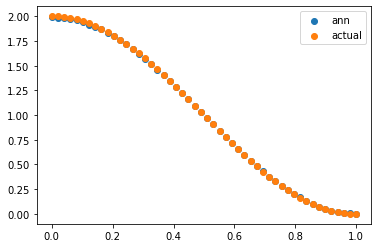

In [380]:
y_pred = model2.predict(x_data_easy)

fig, ax = plt.subplots()

ax.scatter(x_data_easy, y_pred,label='ann')
ax.scatter(x_data_easy, y_data_easy,label='actual')
ax.legend()
plt.show()